In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm, tqdm_pandas
import gc
pd.set_option('display.max_rows', 1000)

In [2]:
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Raízen Data Science Challenge: NYC metro database

Author: Farzin Shams  
Email: farzinshams95@gmail.com

Our data consists of NYC subways' turnstiles registry with multiple samples per day. Variable's descriptions are at:

http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

In [3]:
def read_csv(year):
    df = pd.read_csv(f'./{year}.csv')
    
    df['date'] = df['time'].apply(lambda x: x[:10])
    df['time'] = df['time'].apply(lambda x: x[-8:])
    df = df[['time', 'date', 'ca', 'unit', 'scp', 'station', 'linename', 'division', 'desc', 'entries', 'exits']]
    
    return df

# All work is going to be done using data from 2017 only
year = 2017
df = read_csv(year)

df.sample(3)

,time,date,ca,unit,scp,station,linename,division,desc,entries,exits
1269275,16:00:00,2017-02-15,A022,R022,01-06-01,34 ST-HERALD SQ,BDFMNQRW,BMT,REGULAR,4485137.0,6625675.0
3637627,12:00:00,2017-05-10,N011,R126,01-05-01,175 ST,A,IND,REGULAR,0.0,212.0
717625,20:00:00,2017-01-26,H009,R235,00-03-03,BEDFORD AV,L,BMT,REGULAR,21651356.0,11438186.0


In [4]:
### Audit event type isn't that relevant. Drop it.

df = df.drop('desc', axis=1)

### Removing intraday data

Intraday data is too high of a cardinality to work with (I'll have memory problems). Let's only use daily data. Before doing any EDA, let's remove intraday records. We'll keep the first record for each turnstile.

In [5]:
# The values in the following list uniquely identify a turnstile

identifier = ['ca', 'unit', 'scp', 'station', 'linename', 'division']

In [6]:
### Getting first record of each turnstile per day

def get_first_records(df):
    df = df.sort_values(by='time').groupby(['date'] + identifier).first().reset_index()
    return df
    
df = get_first_records(df)
df.head(3)

,date,ca,unit,scp,station,linename,division,time,entries,exits
0,2017-01-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,5992418.0,2028543.0
1,2017-01-01,A002,R051,02-00-01,59 ST,NQR456W,BMT,00:00:00,5475502.0,1204841.0
2,2017-01-01,A002,R051,02-03-00,59 ST,NQR456W,BMT,00:00:00,842188.0,3132405.0


### What's the time span of the data?

In [7]:
print(f'{df.date.min()} to {df.date.max()}')

2017-01-01 to 2017-05-13


### How many records does each turnstile have?

In [8]:
# Let's see the number of turnstiles

def get_turnstiles_df(df):
    turnstiles = df.groupby(identifier).size().reset_index().rename(columns={0: 'records'}).sort_values('records')
    return turnstiles

turnstiles = get_turnstiles_df(df)
turnstiles.iloc[np.r_[0:20, -5:0]] # Selecting top 20 and bottom 5 groups

,ca,unit,scp,station,linename,division,records
4201,R504,R276,00-FF-01,VERNON-JACKSON,7,IRT,1
2233,N504,R021,02-10-05,42 ST-BRYANT PK,BDFM7,IND,1
1865,N318,R298,00-05-02,NORTHERN BLVD,MR,IND,1
1658,N206,R104,01-00-01,167 ST,BD,IND,1
3405,R194,R040,00-94-00,231 ST,1,IRT,1
1920,N327,R254,00-06-04,GRAND-NEWTOWN,MR,IND,2
4719,TRAM1,R468,00-05-01,RIT-MANHATTAN,R,RIT,2
4717,TRAM1,R468,00-03-01,RIT-MANHATTAN,R,RIT,2
4716,TRAM1,R468,00-03-00,RIT-MANHATTAN,R,RIT,2
906,J037,R009,00-06-00,121 ST,JZ,BMT,39


Text(0.5, 1.0, 'Distribution of records for each turnstile')

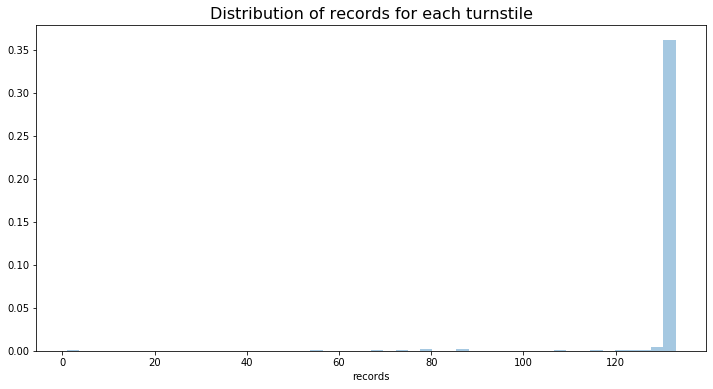

In [9]:
# Distribution of records for each turnstile

plt.figure(figsize=(12,6))
sns.distplot(turnstiles['records'])
plt.title('Distribution of records for each turnstile', fontsize=16)

In [10]:
# Initial number of turnstiles

turnstiles.shape[0]

4726

In [11]:
# 0.5% of turnstiles have less than 60 records. Let's drop them.

THRESHOLD = 60
(turnstiles['records'] < THRESHOLD).sum()/len(turnstiles)

0.0050782903089293275

In [12]:
# Get dataframe with turnstiles to drop

turnstiles_to_drop = turnstiles.query(f'records < {THRESHOLD}')
turnstiles_to_drop.head(3)

,ca,unit,scp,station,linename,division,records
4201,R504,R276,00-FF-01,VERNON-JACKSON,7,IRT,1
2233,N504,R021,02-10-05,42 ST-BRYANT PK,BDFM7,IND,1
1865,N318,R298,00-05-02,NORTHERN BLVD,MR,IND,1


In [13]:
# Drop turnstiles that have less than 'THRESHOLD' records

def drop_turnstiles(df, turnstiles_to_drop):
    df_clean = pd.merge(df, turnstiles_to_drop, on=identifier, indicator=True, how='outer').query('_merge == "left_only"')
    df_clean.drop(['records', '_merge'], axis=1, inplace=True)
    return df_clean

df = drop_turnstiles(df, turnstiles_to_drop)
df.head(3)

,date,ca,unit,scp,station,linename,division,time,entries,exits
0,2017-01-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,5992418.0,2028543.0
1,2017-01-02,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,5993301.0,2028728.0
2,2017-01-03,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,5994282.0,2029042.0


New number of turnstiles:  4702


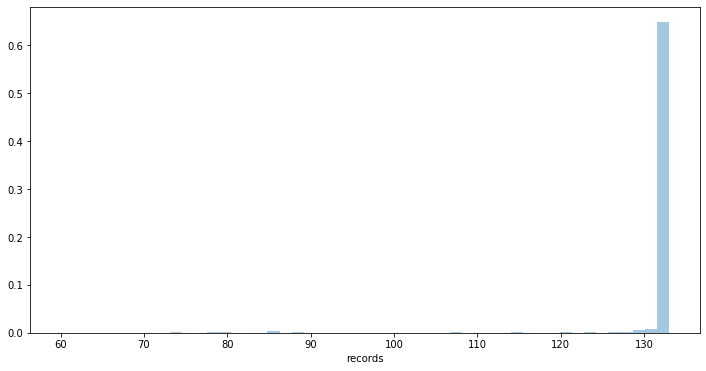

In [14]:
# Creating new turnstiles dataframe

turnstiles = get_turnstiles_df(df)
print('New number of turnstiles: ', turnstiles.shape[0])

plt.figure(figsize=(12,6))
sns.distplot(turnstiles['records'])

### Calculating net number of people per turnstile per day

Let $u$ and $d$ be a turnstile and a date, respectively. The number of people who entered and exited turnstile $u$ in day $d$ are given by 

$\Delta entries_{(u, d)} = entries_{(u, d_{0})} - entries_{(u, (d+1)_{0})} $,

and

$\Delta exits_{(u, d)} = exits_{(u, d_{0})} - exits_{(u, (d+1)_{0})} $,

where $d_{0}$ is the first timestamp on day $d$. So we'll only need $(u, d_{0})$ data. 


In [15]:
### Getting daily delta

def get_delta(df):
    df[['entries', 'exits']] = df.groupby(identifier)[['entries', 'exits']].diff(-1)*-1
    return df.dropna()

### Entries and exits now are the number of people who entered in a specific day only. It's not cumulative anymore.
df = get_delta(df)
df.head(5)

,date,ca,unit,scp,station,linename,division,time,entries,exits
0,2017-01-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,883.0,185.0
1,2017-01-02,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,981.0,314.0
2,2017-01-03,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,1591.0,577.0
3,2017-01-04,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,1664.0,598.0
4,2017-01-05,A002,R051,02-00-00,59 ST,NQR456W,BMT,00:00:00,1695.0,613.0


In [16]:
# Some rows have negative entries and exits field, which doesn´t make any sense. If the original
# values were cumulative, they should only increase.

df = df.query('entries > 0 and exits > 0')

In [17]:
# Putting all operations in a single function

def get_new_df_and_turnstiles(df):
    
    # Get turnstiles df
    turnstiles = get_turnstiles_df(df)

    # Get turnstiles that have < 'THRESHOLD' registers
    turnstiles_to_drop = turnstiles.query(f'records < {THRESHOLD}')

    # Drop those turnstiles
    df = drop_turnstiles(df, turnstiles_to_drop)

    # Get new turnstiles df
    turnstiles = get_turnstiles_df(df)
    
    return df, turnstiles

df, turnstiles = get_new_df_and_turnstiles(df)

In [18]:
# Are there anymore records with negative 'entries' or 'exits' value?

((df['entries'] < 0) |( df['exits'] < 0)).any()

False

In [19]:
# How many turnstiles does the final, clean, dataframe have?

turnstiles.shape[0]

4107

# Exploratory data analysis

Now the data is ready for some adequate EDA.

#### Exploring entries and exits per turnstile

Median log of entries: 3.0008677215312267
Max log of entries: 9.305473973466047


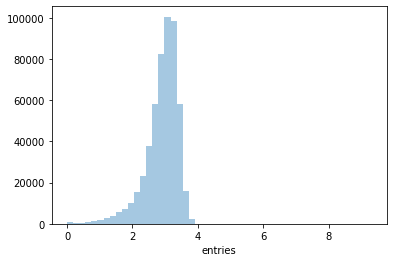

In [20]:
### Distribution of entries per turnstile

entries_log = np.log10(df['entries'])

print('Median log of entries:', entries_log.median())
print('Max log of entries:', entries_log.max())

sns.distplot(np.log10(df['entries']), kde=False)

In [21]:
# The vast majority of turnstiles are below 4000 entries per day

(df['entries'] > 4000).sum()/len(df)

0.017974413161542482

In [22]:
(df['exits'] > 4000).sum()/len(df)

0.01573802652608297

In [23]:
### Drop these outliers

df = df.query('entries <= 4000 and exits <= 4000')

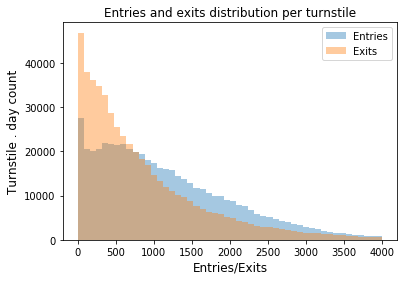

In [24]:
# Drop them and plot new distribution

plt.title('Entries and exits distribution per turnstile')
sns.distplot(df['entries'], kde=False, label='Entries')
sns.distplot(df['exits'], kde=False, label='Exits')
plt.ylabel('Turnstile . day count', fontsize=12)
plt.xlabel('Entries/Exits', fontsize=12)
plt.legend()

### Exploring entries per day

Now, we'll explore total entries per day, not per turnstile

In [25]:
entries_per_day = df.groupby('date').agg({'entries': 'sum'})

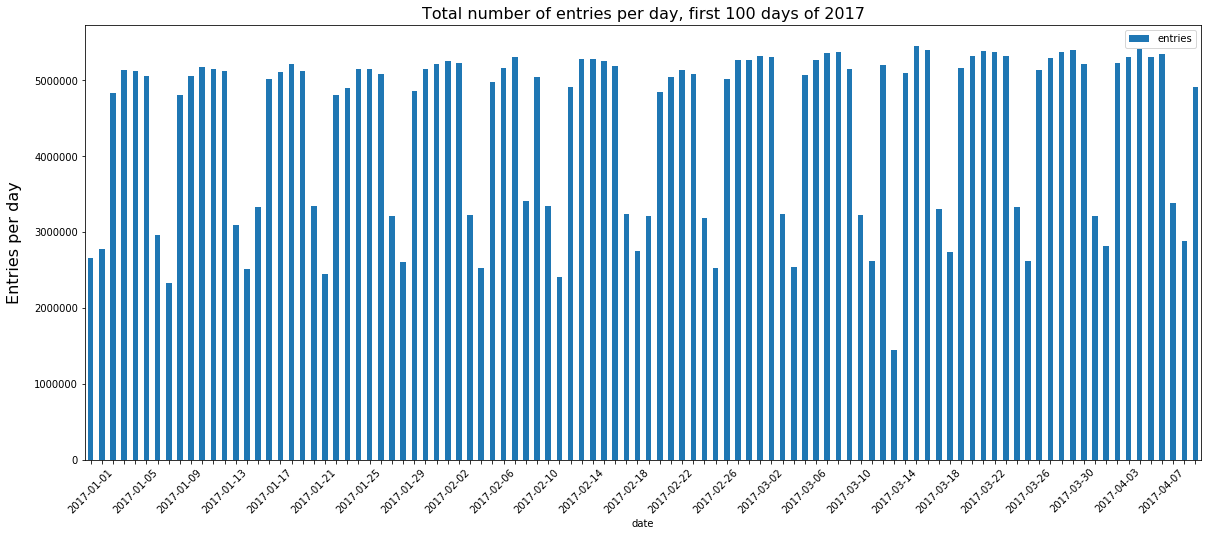

In [26]:
ax = entries_per_day[:100].plot(kind='bar', figsize=(20, 8))

plt.ylabel('Entries per day', fontsize=16, labelpad=12)
plt.title(f'Total number of entries per day, first 100 days of {year}', fontsize=16)

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

_ = plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

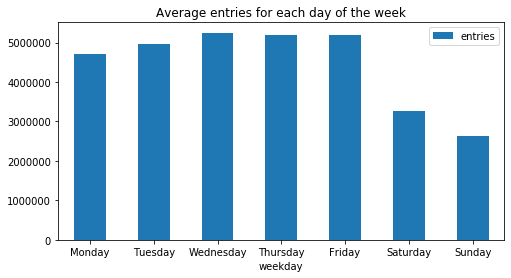

In [27]:
# Presumably, entries data has a weekly periodicity, with smallest values ocurring in weekends.
# Let's check. The following dataframe displays average entries
# per turnstile for each day of the week.

week = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

entries_per_day['weekday'] = entries_per_day.index.map(lambda x: week[datetime.strptime(x, '%Y-%m-%d').weekday()]).values

entries_per_day.groupby('weekday').agg({'entries': 'mean'}).reindex(list(week.values())).plot(kind='bar', figsize=(8,4))

plt.title('Average entries for each day of the week')
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

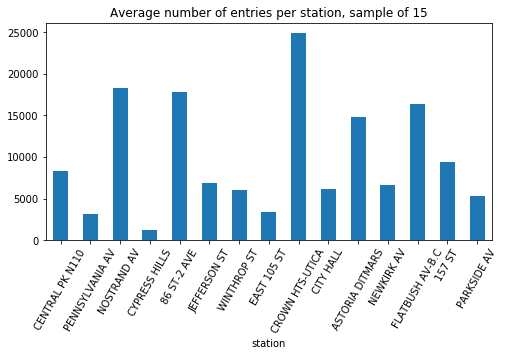

In [28]:
entries_day_station = df.groupby(['date', 'station']).agg({'entries': 'sum'}).reset_index().groupby('station').agg({'entries': 'mean'})

samples = 15

entries_day_station['entries'].sample(samples).plot(kind='bar', figsize=(8,4))
plt.title(f'Average number of entries per station, sample of {samples}')
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

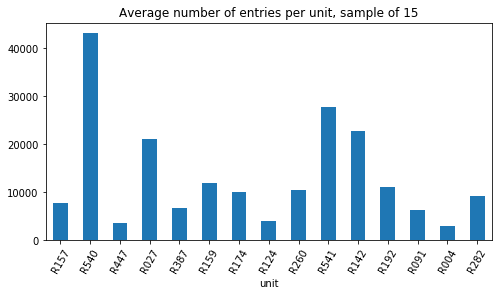

In [29]:
entries_day_unit = df.groupby(['date', 'unit']).agg({'entries': 'sum'}).reset_index().groupby('unit').agg({'entries': 'mean'})

samples = 15

entries_day_unit['entries'].sample(samples).plot(kind='bar', figsize=(8,4))
plt.title(f'Average number of entries per unit, sample of {samples}')
plt.xticks(rotation=60)

### Getting unique values and samples for other columns

In [30]:
for c in ['ca', 'unit', 'station', 'linename', 'scp']:
    print('Column: ', c)
    print('Uniques: ', df[c].nunique())
    print('Samples: ', df[c].sample(5).values)
    print('-----------')

Column:  ca
Uniques:  725
Samples:  ['N119' 'R254' 'PTH17' 'N045' 'N185']
-----------
Column:  unit
Uniques:  465
Samples:  ['R571' 'R113' 'R116' 'R429' 'R088']
-----------
Column:  station
Uniques:  372
Samples:  ['SHEEPSHEAD BAY' '82 ST-JACKSON H' '145 ST' 'JAMAICA CENTER'
 'JKSN HT-ROOSVLT']
-----------
Column:  linename
Uniques:  114
Samples:  ['456NQRW' '456' 'EJZ' 'NQR456W' 'R']
-----------
Column:  scp
Uniques:  201
Samples:  ['00-00-04' '01-00-00' '00-00-01' '00-03-00' '00-00-01']
-----------


## Objective: forecast the number of people who use the subway by day

#### Preparing train and test data

In [31]:
# Preparing Prophet style dataframe. 'entries_per_day' is a dataframe with the time series of total number of entries into
# the NYC subway.

entries_per_day = entries_per_day.reset_index().drop('weekday', axis=1).rename(columns={'date': 'ds', 'entries': 'y'})

entries_per_day['ds'] = entries_per_day['ds'].astype('datetime64[ns]')

entries_per_day.head(5)

,ds,y
0,2017-01-01,2654732.0
1,2017-01-02,2782760.0
2,2017-01-03,4832623.0
3,2017-01-04,5134608.0
4,2017-01-05,5127407.0


In [32]:
# Use last 'TEST_DAYS' as test

TEST_DAYS = 30

entries_per_day_train = entries_per_day[:-TEST_DAYS]
entries_per_day_test = entries_per_day[-TEST_DAYS:]

#### Modelling

In [33]:
from fbprophet import Prophet, plot

In [34]:
# Instantiate Prophet
model = Prophet(yearly_seasonality=False)

# Add US holidays
model.add_country_holidays(country_name='US')

# Fit model to training DF
model.fit(entries_per_day_train)

# Forecast
y_pred = model.predict(entries_per_day_test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot results

Text(0.5, 1, 'Actual vs predicted')

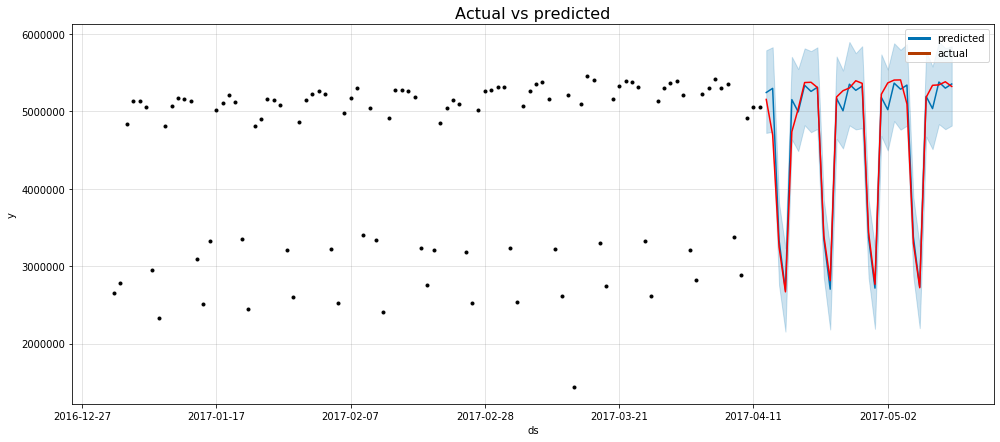

In [35]:
from matplotlib.lines import Line2D

plot.plot(model, y_pred, uncertainty=True, figsize=(14, 6))
plt.plot(entries_per_day_test['ds'], entries_per_day_test['y'], color='r')

colors = ['#0072B2', '#B23B00']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['predicted', 'actual']
plt.legend(lines, labels, fontsize=10)

plt.title('Actual vs predicted', fontsize=16)

In [36]:
# Showing predicted results from 2017-04-13 to 2017-05-12

pd.merge(y_pred[['ds', 'yhat']], entries_per_day_test, on='ds').set_index('ds').astype(int).rename(columns={'yhat': 'prediction', 'y': 'actual'})

,prediction,actual
ds,,
2017-04-13,5241318,5151929
2017-04-14,5294906,4693377
2017-04-15,3337969,3248999
2017-04-16,2689216,2669122
2017-04-17,5149674,4735369
2017-04-18,4991376,5031045
2017-04-19,5334447,5369821
2017-04-20,5255402,5373494
2017-04-21,5308990,5305629


### Validate model

In [37]:
from sklearn.metrics import mean_absolute_error

In [38]:
# Mean number of entries per day

print(int(entries_per_day_test['y'].mean()), 'days')

4651583 days


In [39]:
# Mean absolute error

print(int(mean_absolute_error(entries_per_day_test['y'], y_pred['yhat'])), 'days')

117155 days


In [40]:
# Ratio between prediction MAE and target mean

117155/4651583

0.02518604956635193